In [45]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import os
import pandas as pd

import datetime
import time
from yahoo_historical import Fetcher



os.chdir(r'C:\Users\hadit\OneDrive - Prophix Software, Inc\AutoTrading')

 
# load dataset
ticker = 'ETH-CAD'
#dstart = '1-1-2021' #start date of data to calculate rolling averages
actual_start = '1-1-2022' # actual start date where data is analyzed

#dstart = datetime.datetime.strptime(actual_start, '%m-%d-%Y') -datetime.timedelta(days = 50) 
dstart = datetime.datetime.strptime(actual_start, '%m-%d-%Y')
print(dstart)
dstart = time.mktime(dstart.timetuple())
df = Fetcher(ticker, dstart).get_historical()
df.Date = pd.to_datetime(df.Date)
dates = df.Date

df.columns



2022-01-01 00:00:00


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [46]:
df['close_50'] = df.Close.ewm(span=50,adjust=False).mean()
df['close_12'] = df.Close.ewm(span=12,adjust=False).mean()

In [47]:
df['signal_ema50'] = df.Close>df.close_50
df['signal_ema50'] = df['signal_ema50'].astype(int)
df['signal_ema12'] = df.Close>df.close_12
df['signal_ema12'] = df['signal_ema12'].astype(int)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,close_50,close_12,signal_ema50,signal_ema12
365,2023-01-01,1623.880615,1631.383057,1618.685913,1625.373779,1625.373779,3.247696e+09,1694.545791,1640.796275,0,0
366,2023-01-02,1625.561157,1656.265747,1616.793701,1647.529907,1647.529907,5.107781e+09,1692.702031,1641.832219,0,1
367,2023-01-03,1647.648438,1653.166504,1652.023560,1660.974365,1660.974365,4.639231e+09,1691.457809,1644.777164,0,1
368,2023-01-04,1660.891968,1707.519165,1657.093994,1694.551758,1694.551758,8.636997e+09,1691.579140,1652.434794,1,1
369,2023-01-05,NaN,NaN,NaN,NaN,NaN,NaN,1691.579140,1652.434794,0,0


In [48]:
samp = df[df.Date>=pd.to_datetime('2022-9-1')]

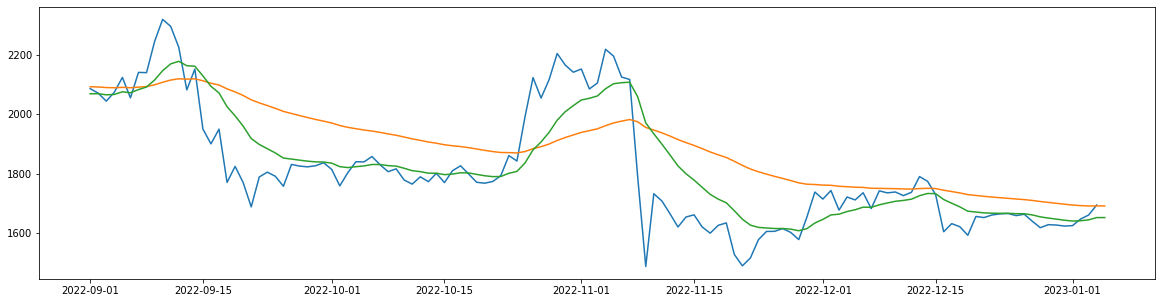

In [49]:
pyplot.figure(figsize=(20,5))
pyplot.plot(samp.Date, samp.Close)
pyplot.plot(samp.Date, samp.close_50)
pyplot.plot(samp.Date, samp.close_12)

In [50]:
y = df.Close.shift(-1) - df.Close
y = y>0
y  = y.astype(int)
df['y'] = y

N = df.shape[1]


In [51]:
df.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume,close_50,close_12,signal_ema50,signal_ema12,y
360,2022-12-27,1663.733154,1668.880005,1627.873413,1640.312866,1640.312866,5.533836e+09,1709.983759,1661.408370,0,0,0
361,2022-12-28,1640.238403,1641.254272,1613.023315,1618.496460,1618.496460,6.789155e+09,1706.396021,1654.806538,0,0,1
362,2022-12-29,1618.529297,1631.660034,1615.487915,1628.673584,1628.673584,5.600937e+09,1703.348083,1650.786084,0,0,0
363,2022-12-30,1628.638672,1629.492676,1608.004761,1627.291748,1627.291748,5.503315e+09,1700.365481,1647.171570,0,0,0
364,2022-12-31,1627.464478,1635.245117,1620.474731,1623.958740,1623.958740,4.095972e+09,1697.369139,1643.600366,0,0,1
365,2023-01-01,1623.880615,1631.383057,1618.685913,1625.373779,1625.373779,3.247696e+09,1694.545791,1640.796275,0,0,1
366,2023-01-02,1625.561157,1656.265747,1616.793701,1647.529907,1647.529907,5.107781e+09,1692.702031,1641.832219,0,1,1
367,2023-01-03,1647.648438,1653.166504,1652.023560,1660.974365,1660.974365,4.639231e+09,1691.457809,1644.777164,0,1,1
368,2023-01-04,1660.891968,1707.519165,1657.093994,1694.551758,1694.551758,8.636997e+09,1691.579140,1652.434794,1,1,0
369,2023-01-05,NaN,NaN,NaN,NaN,NaN,NaN,1691.579140,1652.434794,0,0,0


In [52]:
df.apply(lambda x: x.isnull().sum())

Date            0
Open            1
High            1
Low             1
Close           1
Adj Close       1
Volume          1
close_50        0
close_12        0
signal_ema50    0
signal_ema12    0
y               0
dtype: int64

In [53]:
df[df.Open.isnull()]

,Date,Open,High,Low,Close,Adj Close,Volume,close_50,close_12,signal_ema50,signal_ema12,y
369,2023-01-05,NaN,NaN,NaN,NaN,NaN,NaN,1691.57914,1652.434794,0,0,0


In [55]:
df.shape

(370, 12)

In [56]:
df.dropna(inplace=True)
df.shape

(369, 12)

In [57]:
df.drop(['Date','Adj Close'], axis=1, inplace=True)


In [58]:
df.head()

,Open,High,Low,Close,Volume,close_50,close_12,signal_ema50,signal_ema12,y
0,4655.555664,4765.364746,4654.594238,4765.085449,1.235759e+10,4765.085449,4765.085449,0,0,1
1,4764.581543,4842.118652,4711.566406,4848.099121,1.250961e+10,4768.340887,4777.856783,1,1,0
2,4848.062012,4888.744141,4717.070801,4796.455566,1.540523e+10,4769.443424,4780.718134,1,1,1
3,4796.431641,4927.568359,4744.676270,4820.447754,1.782666e+10,4771.443593,4786.830384,1,1,0
4,4820.717773,4883.027344,4409.953125,4530.520996,2.304742e+10,4761.995648,4747.398170,0,0,0


In [59]:
# split into train and test sets
values = df.values
#n_train_hours = 365 * 24
train = values[:round(0.8*values.shape[0]), :]
test = values[round(0.8*values.shape[0]):, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]


print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(295, 9) (295,) (74, 9) (74,)


In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model.fit(train_X, train_y)
y_pred = model.predict(test_X)
acc_base_logreg = accuracy_score(test_y, y_pred)
acc_base_logreg

0.5

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
#from skopt import BayesSearchCV


# Number of trees in random forest
import numpy as np
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 10, num = 6)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               #'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid



{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [5, 6, 7, 8, 9, 10, None],
 'bootstrap': [True, False]}

In [62]:
'''
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(train_X, train_y)
rf_random.best_params_

y_pred = rf_random.predict(test_X)

acc_tuned = accuracy_score(y_pred, test_y)

rf = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf.fit(train_X, train_y)
y_pred = rf.predict(test_X)
acc_base = accuracy_score(test_y, y_pred)
'''

'\nrf = RandomForestClassifier()\nrf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model\nrf_random.fit(train_X, train_y)\nrf_random.best_params_\n\ny_pred = rf_random.predict(test_X)\n\nacc_tuned = accuracy_score(y_pred, test_y)\n\nrf = RandomForestClassifier(n_estimators = 100, random_state = 0)\nrf.fit(train_X, train_y)\ny_pred = rf.predict(test_X)\nacc_base = accuracy_score(test_y, y_pred)\n'

In [63]:
#train_y

In [64]:
from xgboost import XGBClassifier
model = XGBClassifier(subsample = 0.9)
#model = XGBClassifier()
#model.fit(train_X, train_y)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, train_X, train_y, scoring='accuracy',
                         cv=3, n_jobs=-1)
print(scores)
scores.mean()
#y_pred = model.predict(test_X)
#acc_xgb = accuracy_score(test_y, y_pred)

[0.4040404  0.43877551 0.51020408]


0.4510066652923796

In [81]:
import numpy as np
np.mean([(1-score) for score in scores])

0.5489933347076205

In [65]:
import xgboost as xgb


In [66]:
'''
from sklearn.datasets import make_classification
num_boost_round = 100
num_classes = 3
X, y = make_classification(n_samples=1000, n_informative=5,
                           n_classes=num_classes)
dtrain = xgb.DMatrix(data=X, label=y)
dtest = xgb.DMatrix(data=X)

# total number of built trees is num_parallel_tree * num_classes * num_boost_round

# We build a boosted random forest for classification here.
booster = xgb.train({
    'num_parallel_tree': 4, 'subsample': 0.5, 'num_class': 3},
                    num_boost_round=num_boost_round, dtrain=dtrain)

# This is the sliced model, containing [3, 7) forests
# step is also supported with some limitations like negative step is invalid.
sliced: xgb.Booster = booster[3:7]

# Access individual tree layer
trees = [_ for _ in booster]
assert len(trees) == num_boost_round
'''

"\nfrom sklearn.datasets import make_classification\nnum_boost_round = 100\nnum_classes = 3\nX, y = make_classification(n_samples=1000, n_informative=5,\n                           n_classes=num_classes)\ndtrain = xgb.DMatrix(data=X, label=y)\ndtest = xgb.DMatrix(data=X)\n\n# total number of built trees is num_parallel_tree * num_classes * num_boost_round\n\n# We build a boosted random forest for classification here.\nbooster = xgb.train({\n    'num_parallel_tree': 4, 'subsample': 0.5, 'num_class': 3},\n                    num_boost_round=num_boost_round, dtrain=dtrain)\n\n# This is the sliced model, containing [3, 7) forests\n# step is also supported with some limitations like negative step is invalid.\nsliced: xgb.Booster = booster[3:7]\n\n# Access individual tree layer\ntrees = [_ for _ in booster]\nassert len(trees) == num_boost_round\n"

In [67]:
#booster.predict(dtest)

In [68]:
num_boost_round = 100
dtrain = xgb.DMatrix(data=train_X, label=train_y)
dtest = xgb.DMatrix(data = test_X)
booster = xgb.train({
    'num_parallel_tree': 10, 'subsample':0.9, 'num_class': 2},
                    num_boost_round=num_boost_round, dtrain=dtrain)
y_pred = booster.predict(dtest)
acc_xgb = accuracy_score(test_y, y_pred)
acc_xgb
#y_pred

0.527027027027027

In [69]:
'''
param_space = dict(n_estimators=n_estimators,
                   max_features = max_features,
                   max_depth = max_depth,
                   bootstrap = bootstrap
                   )
'''

'\nparam_space = dict(n_estimators=n_estimators,\n                   max_features = max_features,\n                   max_depth = max_depth,\n                   bootstrap = bootstrap\n                   )\n'

## Do hyperpameter tuning using hyperopt (bayesian opt)

In [70]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [85]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        #'n_estimators': 180,
        'seed': 0
    }

In [98]:
def objective(space):
    model=xgb.XGBClassifier(
                    max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    scores = cross_val_score(model, train_X, train_y, scoring='accuracy',
                         cv=3, n_jobs=-1)   


    accuracy = scores.mean()
    import numpy as np
    loss = np.mean([(1-score) for score in scores])
    print ("SCORE:", accuracy)
    return {'loss': loss, 'status': STATUS_OK }

In [99]:
'''
def objective(space):
    clf=xgb.XGBClassifier(
                    max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( train_X, train_y), (test_X, test_y)]
    
    clf.fit(train_X, train_y,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    
    pred = clf.predict(test_X)
    accuracy = accuracy_score(test_y, pred>0.5)
    #accuracy = scores.mean()
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }
'''

'\ndef objective(space):\n    clf=xgb.XGBClassifier(\n                    max_depth = int(space[\'max_depth\']), gamma = space[\'gamma\'],\n                    reg_alpha = int(space[\'reg_alpha\']),min_child_weight=int(space[\'min_child_weight\']),\n                    colsample_bytree=int(space[\'colsample_bytree\']))\n    \n    evaluation = [( train_X, train_y), (test_X, test_y)]\n    \n    clf.fit(train_X, train_y,\n            eval_set=evaluation, eval_metric="auc",\n            early_stopping_rounds=10,verbose=False)\n    \n    pred = clf.predict(test_X)\n    accuracy = accuracy_score(test_y, pred>0.5)\n    #accuracy = scores.mean()\n    print ("SCORE:", accuracy)\n    return {\'loss\': -accuracy, \'status\': STATUS_OK }\n'

In [100]:
import warnings
warnings.filterwarnings("ignore")

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                                                                                 
0.515254586683158                                                                                                      
SCORE:                                                                                                                 
0.515254586683158                                                                                                      
SCORE:                                                                                                                 
0.515254586683158                                                                                                      
SCORE:                                                                                                                 
0.515254586683158                                                                                                      
SCORE:                                  

SCORE:                                                                                                                 
0.515254586683158                                                                                                      
SCORE:                                                                                                                 
0.515254586683158                                                                                                      
SCORE:                                                                                                                 
0.515254586683158                                                                                                      
SCORE:                                                                                                                 
0.515254586683158                                                                                                      
SCORE:                                  

SCORE:                                                                                                                 
0.515254586683158                                                                                                      
SCORE:                                                                                                                 
0.515254586683158                                                                                                      
SCORE:                                                                                                                 
0.515254586683158                                                                                                      
SCORE:                                                                                                                 
0.515254586683158                                                                                                      
SCORE:                                  

In [76]:
print(best_hyperparams)

{'colsample_bytree': 0.9086928805970003, 'gamma': 4.720462745698613, 'max_depth': 16.0, 'min_child_weight': 4.0, 'reg_alpha': 139.0, 'reg_lambda': 0.7626714248824468}
